<a href="https://colab.research.google.com/github/verykurniabakti/pico-w-vkb/blob/main/percobaan_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# --- load data dan clean data ---
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load data dan bersihkan format koma
df = pd.read_csv("data.ka.siap.csv", sep=";", encoding="latin-1")
numeric_cols = ['ax', 'ay', 'az', 'gx', 'gy', 'gz']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='coerce')

# Buang baris yang mengandung NaN
df_clean = df.dropna(subset=numeric_cols + ['label']).copy()
df_clean.reset_index(drop=True, inplace=True)

# --- Preprocessing ---
# 1. Hilangkan offset (zeromean)
for col in numeric_cols:
    df_clean[col] -= df_clean[col].mean()

# 2. (Opsional) Standardisasi ke z-score
scaler = StandardScaler()
df_clean[numeric_cols] = scaler.fit_transform(df_clean[numeric_cols])

# 3. Simpan versi hasil preprocessing
df_clean.to_csv("data_ka_ready_fft.csv", index=False)

print(f"✅ Preprocessing selesai: {len(df)} → {len(df_clean)} baris, data siap untuk FFT!")


FileNotFoundError: [Errno 2] No such file or directory: 'data.ka.siap.csv'

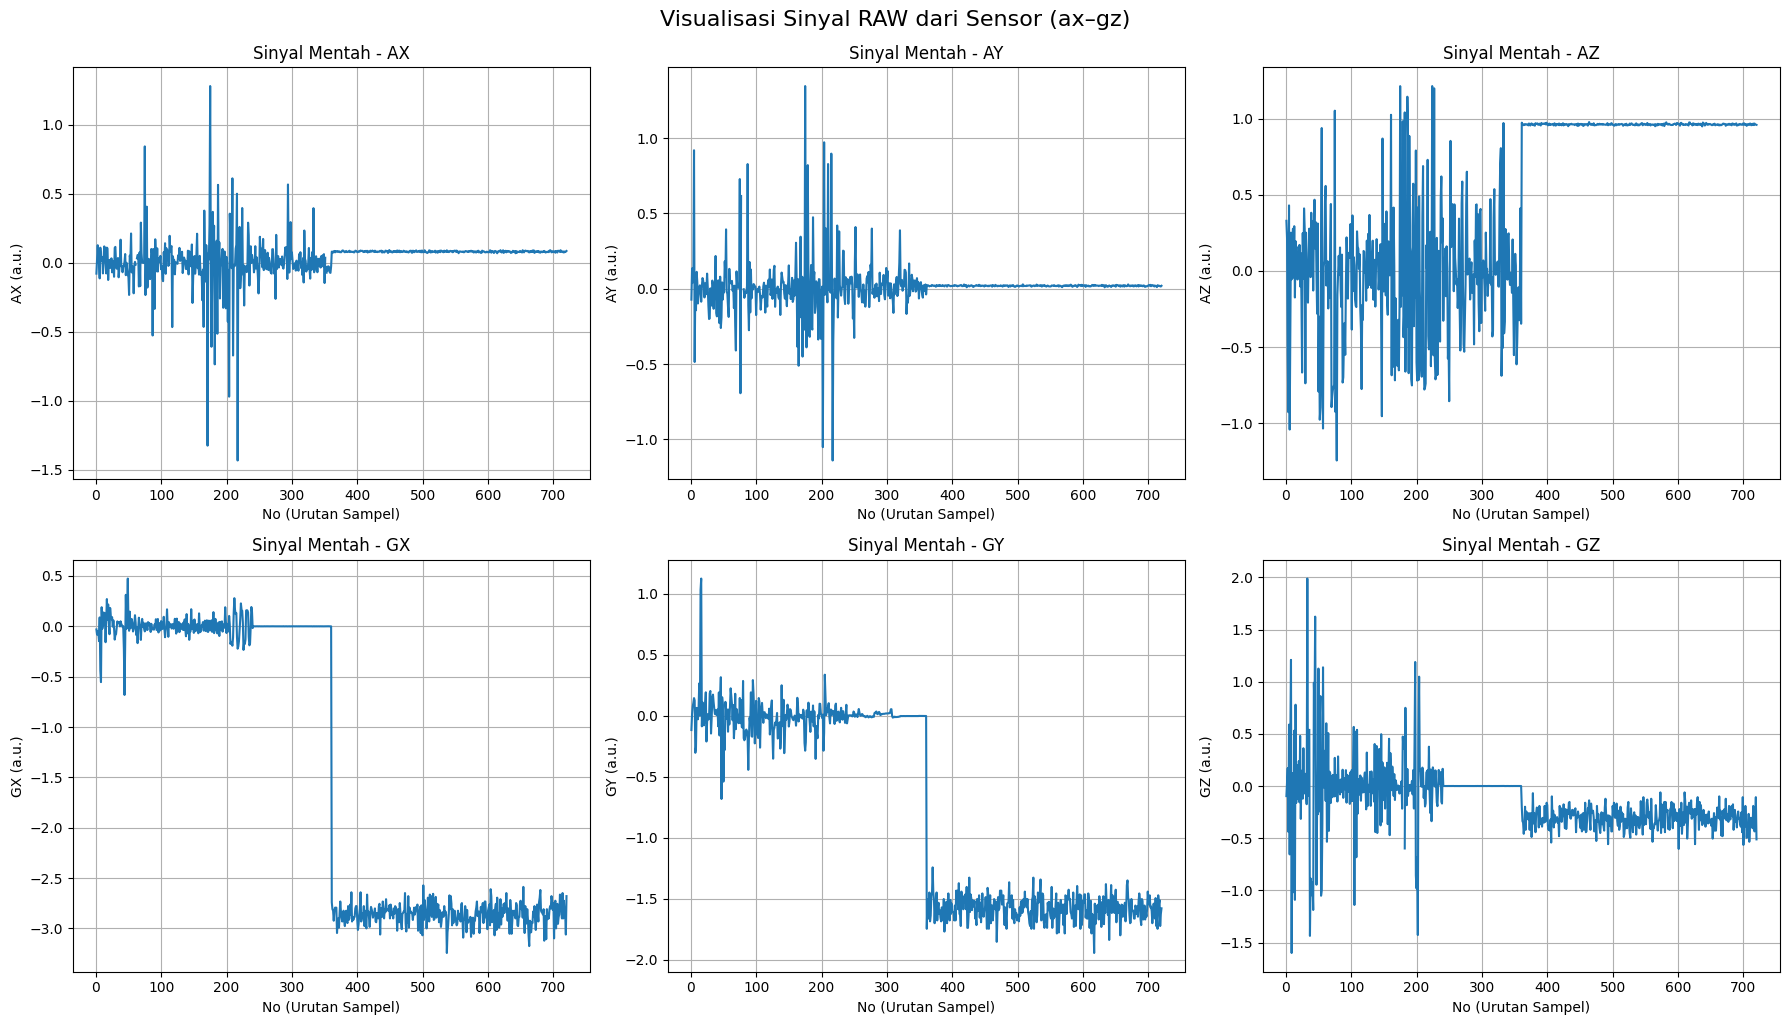

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data RAW dan parsing desimal koma
df = pd.read_csv("data_ka_raw_siap.csv", sep=";", encoding="latin-1")

# Daftar kolom numerik
numeric_cols = ['ax', 'ay', 'az', 'gx', 'gy', 'gz']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace(",", "."), errors='coerce')

# Pastikan kolom No digunakan sebagai sumbu waktu relatif
x_axis = df["No"]

# Buat plot 2x3 untuk semua kanal sensor
plt.figure(figsize=(18, 10))
for idx, col in enumerate(numeric_cols):
    plt.subplot(2, 3, idx + 1)
    plt.plot(x_axis, df[col], label=col.upper(), color='tab:blue')
    plt.xlabel("No (Urutan Sampel)")
    plt.ylabel(f"{col.upper()} (a.u.)")
    plt.title(f"Sinyal Mentah - {col.upper()}")
    plt.grid(True)
    plt.tight_layout()

plt.suptitle("Visualisasi Sinyal RAW dari Sensor (ax–gz)", fontsize=16, y=1.02)
plt.show()


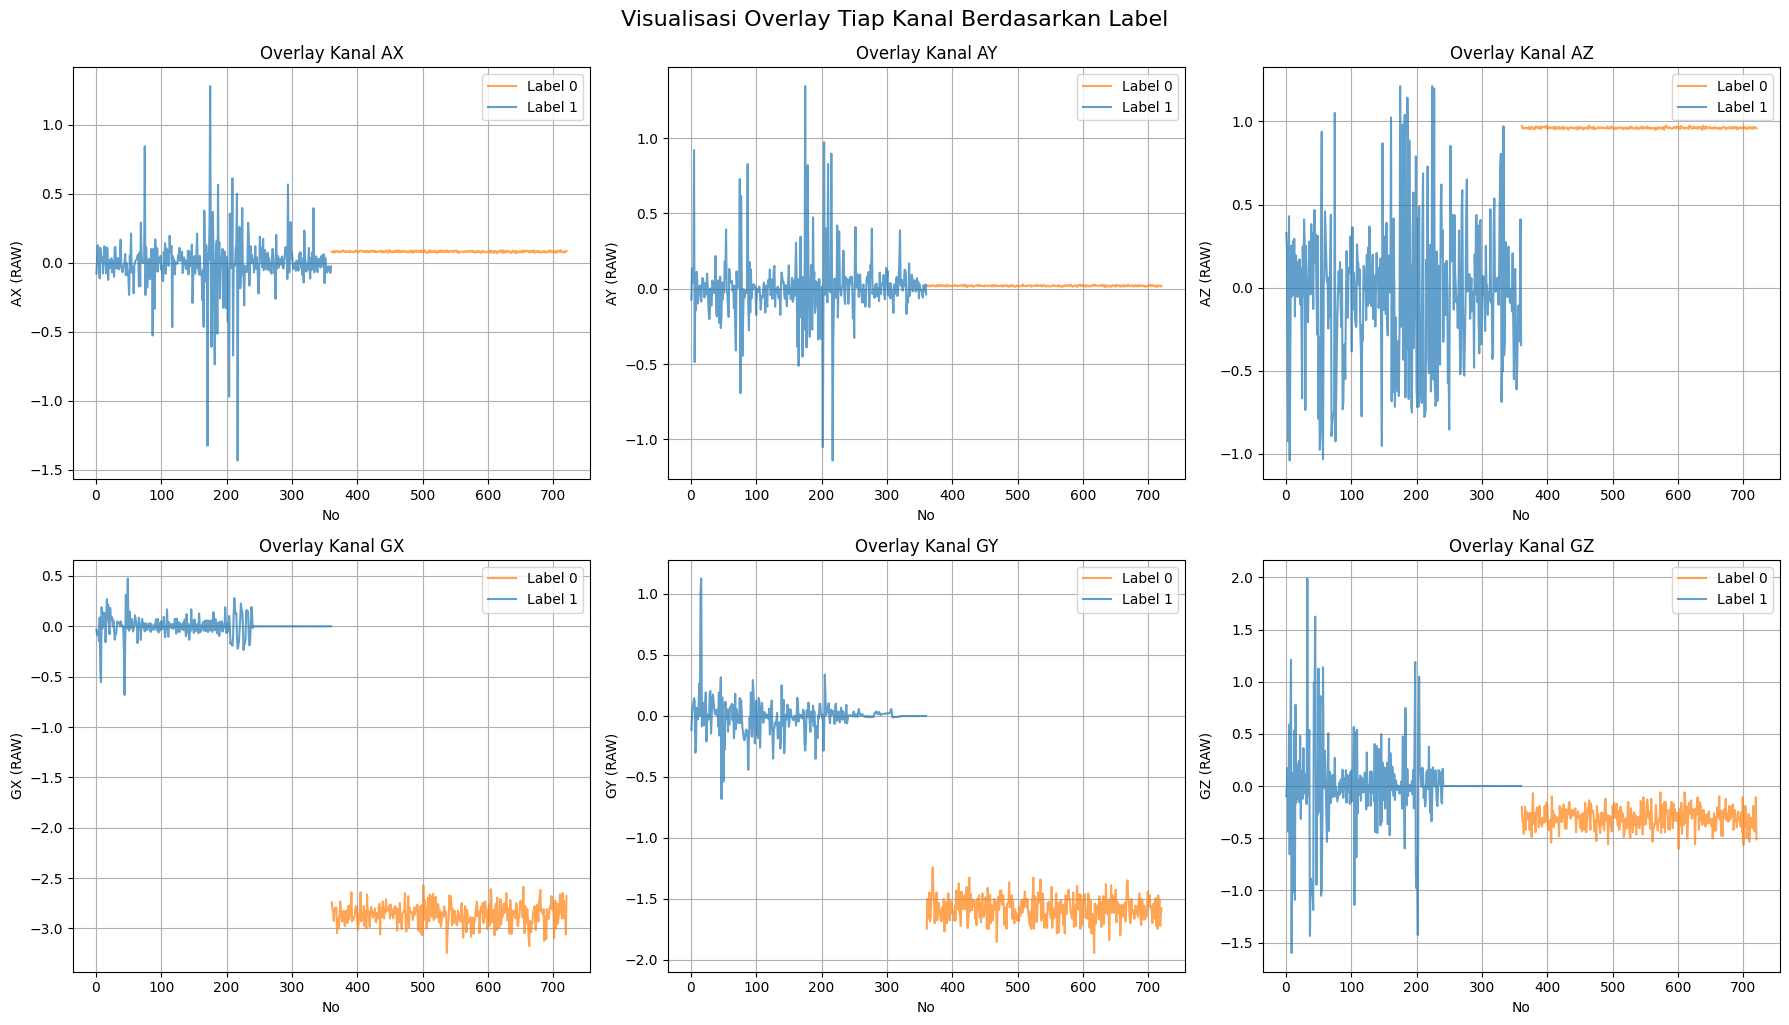

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dan parsing awal
df = pd.read_csv("data_ka_raw_siap.csv", sep=";", encoding="latin-1")
numeric_cols = ['ax', 'ay', 'az', 'gx', 'gy', 'gz']

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace(",", "."), errors='coerce')

df['label'] = pd.to_numeric(df['label'], errors='coerce')
df = df.dropna(subset=numeric_cols + ['label'])

# Buat plot overlay untuk setiap kanal
import matplotlib.cm as cm
colors = {0: 'tab:orange', 1: 'tab:blue'}

plt.figure(figsize=(18, 10))
for idx, col in enumerate(numeric_cols):
    plt.subplot(2, 3, idx + 1)
    for label in [0, 1]:
        subset = df[df['label'] == label]
        plt.plot(subset['No'], subset[col], label=f"Label {label}", alpha=0.7, color=colors[label])
    plt.title(f"Overlay Kanal {col.upper()}")
    plt.xlabel("No")
    plt.ylabel(f"{col.upper()} (RAW)")
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.suptitle("Visualisasi Overlay Tiap Kanal Berdasarkan Label", fontsize=16, y=1.02)
plt.show()


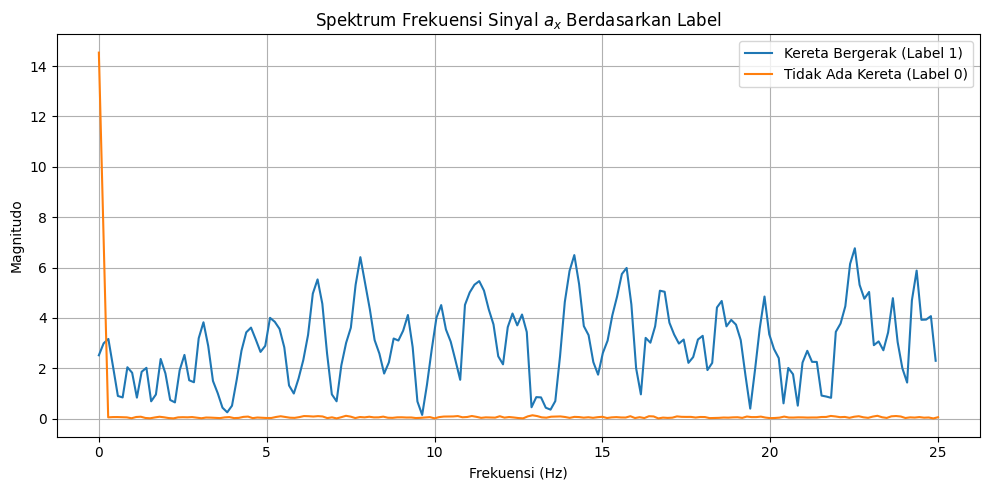

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data RAW
df = pd.read_csv("data_ka_raw_siap.csv", sep=';', encoding='latin-1')

# Parse koma ke titik & konversi numerik
for col in ['ax', 'ay', 'az', 'gx', 'gy', 'gz']:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='coerce')
df['label'] = pd.to_numeric(df['label'], errors='coerce')
df.dropna(inplace=True)

# Sampling rate (misalnya)
fs = 50  # Hz

# Pilih contoh segmen untuk masing-masing label
N = 512  # panjang segmen
segment_label1 = df[df['label'] == 1]['ax'].values[:N]
segment_label0 = df[df['label'] == 0]['ax'].values[:N]

# Fungsi FFT & plotting
def plot_fft(signal, fs, title):
    N = len(signal)
    f = np.fft.rfftfreq(N, d=1/fs)
    X = np.fft.rfft(signal * np.hanning(N))
    magnitude = np.abs(X)

    plt.plot(f, magnitude, label=title)
    plt.xlabel("Frekuensi (Hz)")
    plt.ylabel("Magnitudo")
    plt.grid(True)

# Plot spektrum keduanya
plt.figure(figsize=(10, 5))
plot_fft(segment_label1, fs, "Kereta Bergerak (Label 1)")
plot_fft(segment_label0, fs, "Tidak Ada Kereta (Label 0)")
plt.title("Spektrum Frekuensi Sinyal $a_x$ Berdasarkan Label")
plt.legend()
plt.tight_layout()
plt.show()


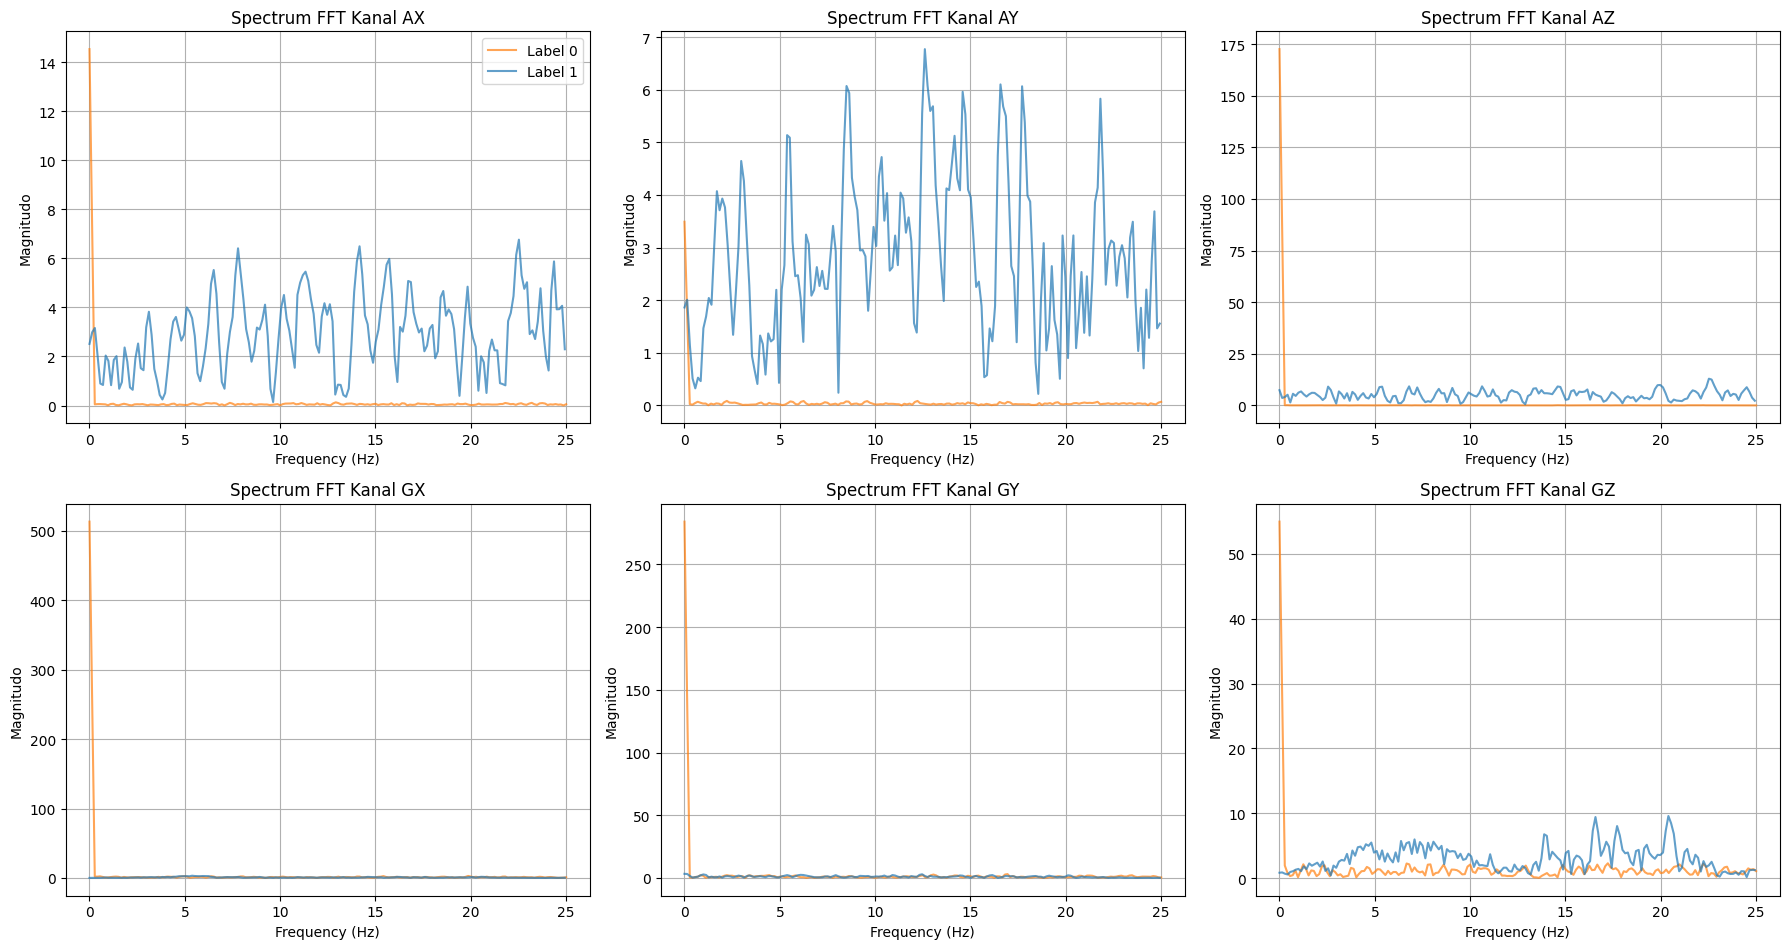

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data dan preprocessing numerik
df = pd.read_csv("data_ka_raw_siap.csv", sep=";", encoding="latin-1")
sensor_cols = ['ax', 'ay', 'az', 'gx', 'gy', 'gz']

for col in sensor_cols:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace(",", "."), errors='coerce')
df['label'] = pd.to_numeric(df['label'], errors='coerce')
df.dropna(inplace=True)

# Sampling rate estimasi
fs = 50  # Hz
N = 512  # panjang segmen FFT

# Ambil data untuk masing-masing label (label 0 dan 1)
label0 = df[df['label'] == 0].iloc[:N]
label1 = df[df['label'] == 1].iloc[:N]

# Fungsi plotting FFT untuk satu kanal
def compute_fft(signal, fs):
    windowed = signal * np.hanning(len(signal))
    fft_vals = np.fft.rfft(windowed)
    freqs = np.fft.rfftfreq(len(signal), 1/fs)
    magnitude = np.abs(fft_vals)
    return freqs, magnitude

# Buat subplot grid 2x3
plt.figure(figsize=(18, 10))
for i, col in enumerate(sensor_cols):
    plt.subplot(2, 3, i + 1)

    # FFT label 0 dan 1
    f0, mag0 = compute_fft(label0[col].values, fs)
    f1, mag1 = compute_fft(label1[col].values, fs)

    # Plot keduanya
    plt.plot(f0, mag0, label="Label 0", color="tab:orange", alpha=0.7)
    plt.plot(f1, mag1, label="Label 1", color="tab:blue", alpha=0.7)
    plt.title(f"Spectrum FFT Kanal {col.upper()}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitudo")
    plt.grid(True)
    if i == 0:
        plt.legend()
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [11]:
import pandas as pd
import numpy as np

from scipy.fft import rfft, rfftfreq
from scipy.stats import entropy

# Parameter
fs = 50           # Sampling rate (Hz)
win_size = 256    # Window length
step = 128        # Overlap 50%
sensor_cols = ['ax', 'ay', 'az', 'gx', 'gy', 'gz']

df = pd.read_csv("data_ka_raw_siap.csv", sep=";", encoding="latin-1")
for col in sensor_cols:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace(",", "."), errors='coerce')
df['label'] = pd.to_numeric(df['label'], errors='coerce')
df.dropna(inplace=True)
data = df.reset_index(drop=True)

features = []

for start in range(0, len(data) - win_size, step):
    end = start + win_size
    window = data.iloc[start:end]
    row = {}

    for col in sensor_cols:
        signal = window[col].values * np.hanning(win_size)
        X = np.abs(rfft(signal))
        P = X**2 / np.sum(X**2)  # power spectrum

        row[f'{col}_mean'] = np.mean(signal)
        row[f'{col}_std'] = np.std(signal)
        row[f'{col}_rms'] = np.sqrt(np.mean(signal**2))
        row[f'{col}_entropy'] = entropy(P)
        row[f'{col}_fdom'] = rfftfreq(win_size, d=1/fs)[np.argmax(X)]

    # Majority vote label
    row['label'] = int(window['label'].mode().iloc[0])
    features.append(row)

df_feat = pd.DataFrame(features)
print(df_feat.head())


    ax_mean    ax_std    ax_rms  ax_entropy    ax_fdom   ay_mean    ay_std  \
0 -0.006318  0.141165  0.141307    4.541822  14.257812  0.000344  0.134235   
1 -0.000491  0.116732  0.116733    4.399310  14.062500  0.010506  0.118167   
2  0.029521  0.040269  0.049930    2.035835   0.000000  0.009117  0.020225   
3  0.040410  0.028940  0.049705    0.527352   0.000000  0.009640  0.007064   

     ay_rms  ay_entropy    ay_fdom  ...    gy_std    gy_rms  gy_entropy  \
0  0.134236    4.457059  14.648438  ...  0.078116  0.079882    4.247442   
1  0.118633    4.428745   2.148438  ...  0.042917  0.043566    3.848822   
2  0.022185    3.609884   0.000000  ...  0.638734  0.857920    1.022271   
3  0.011951    0.644782   0.000000  ...  0.563805  0.968641    0.529000   

    gy_fdom   gz_mean    gz_std    gz_rms  gz_entropy    gz_fdom  label  
0  0.000000  0.002558  0.188840  0.188857    4.113889  20.312500      1  
1  0.195312 -0.001027  0.101488  0.101493    4.316086  16.601562      1  
2  0.000000

In [12]:
# prompt: jadikal data diatas ke format excel dan simpan

# Simpan DataFrame ke format Excel
df_feat.to_excel("data_ka_features.xlsx", index=False)

print(f"✅ DataFrame features berhasil disimpan ke data_ka_features.xlsx")


✅ DataFrame features berhasil disimpan ke data_ka_features.xlsx


/tmp/ipython-input-13-2667899367.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_feat, x='label', y=feat, palette='Set2', inner='box')
/tmp/ipython-input-13-2667899367.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_feat, x='label', y=feat, palette='Set2', inner='box')
/tmp/ipython-input-13-2667899367.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_feat, x='label', y=feat, palette='Set2', inner='box')
/tmp/ipython-input-13-2667899367.py:14: FutureWarning: 

Passing `palette` without assigning `

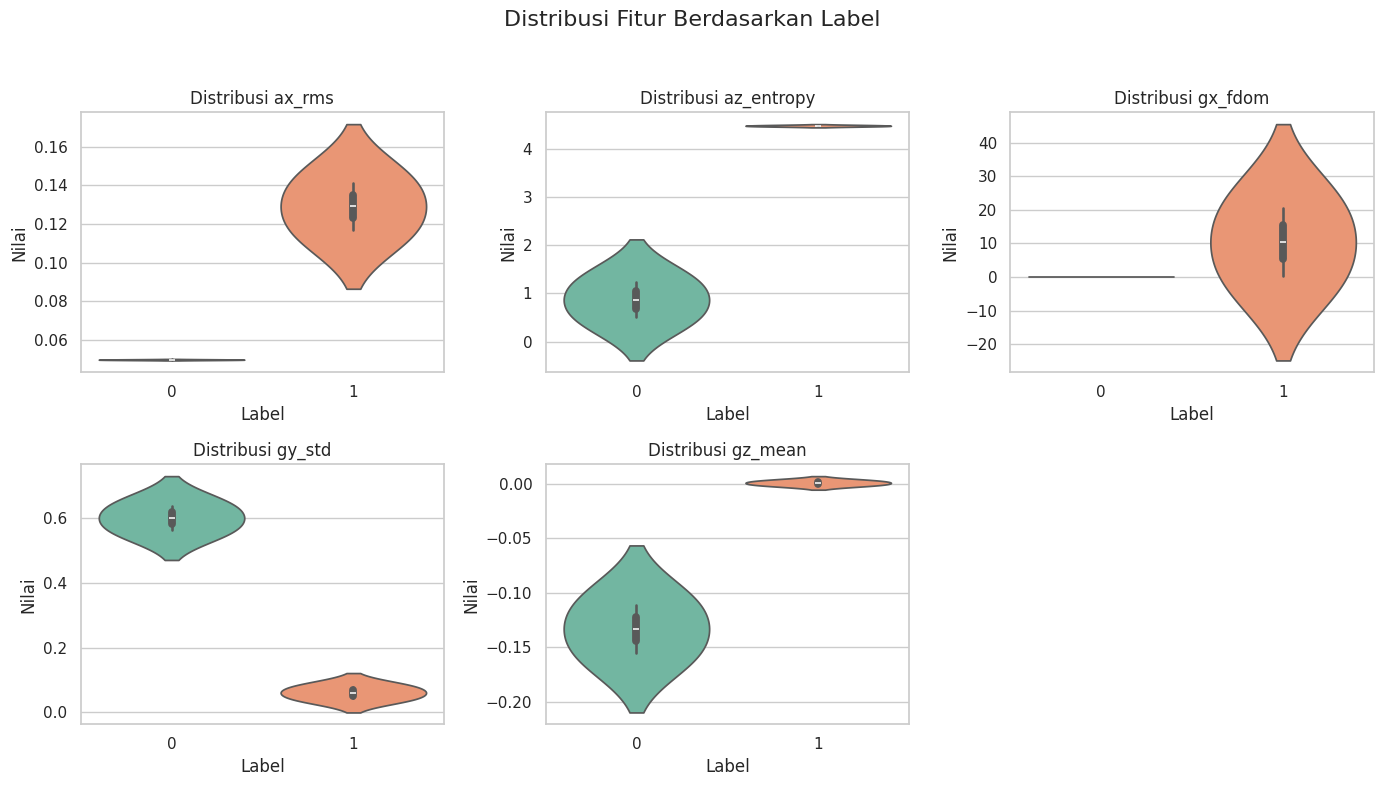

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pilih subset fitur yang ingin divisualisasikan
pilih_fitur = ['ax_rms', 'az_entropy', 'gx_fdom', 'gy_std', 'gz_mean']  # contoh

# Set gaya visual
sns.set(style="whitegrid")

# Plot distribusi per fitur
plt.figure(figsize=(14, 8))
for idx, feat in enumerate(pilih_fitur):
    plt.subplot(2, 3, idx + 1)
    sns.violinplot(data=df_feat, x='label', y=feat, palette='Set2', inner='box')
    plt.title(f'Distribusi {feat}')
    plt.xlabel("Label")
    plt.ylabel("Nilai")

plt.suptitle("Distribusi Fitur Berdasarkan Label", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Pisahkan fitur dan label
X = df_feat.drop(columns=['label'])
y = df_feat['label']

# Split training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Skala fitur (wajib untuk SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [15]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# SVM Linear
svm_lin = SVC(kernel='linear', C=1)
svm_lin.fit(X_train_scaled, y_train)

# SVM RBF
svm_rbf = SVC(kernel='rbf', C=1, gamma='scale')
svm_rbf.fit(X_train_scaled, y_train)

# Prediksi dan evaluasi
for model, name in zip([svm_lin, svm_rbf], ['SVM Linear', 'SVM RBF']):
    print(f"\n📌 {name}")
    y_pred = model.predict(X_test_scaled)
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred, digits=4))



📌 SVM Linear
Confusion Matrix:
[[1 0]
 [0 1]]
Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         1
           1     1.0000    1.0000    1.0000         1

    accuracy                         1.0000         2
   macro avg     1.0000    1.0000    1.0000         2
weighted avg     1.0000    1.0000    1.0000         2


📌 SVM RBF
Confusion Matrix:
[[1 0]
 [0 1]]
Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         1
           1     1.0000    1.0000    1.0000         1

    accuracy                         1.0000         2
   macro avg     1.0000    1.0000    1.0000         2
weighted avg     1.0000    1.0000    1.0000         2



In [14]:
# prompt: simpan hasilnya ke excel

# Simpan DataFrame ke format Excel
df_feat.to_excel("data_ka_features.xlsx", index=False)

print(f"✅ DataFrame features berhasil disimpan ke data_ka_features.xlsx")

✅ DataFrame features berhasil disimpan ke data_ka_features.xlsx


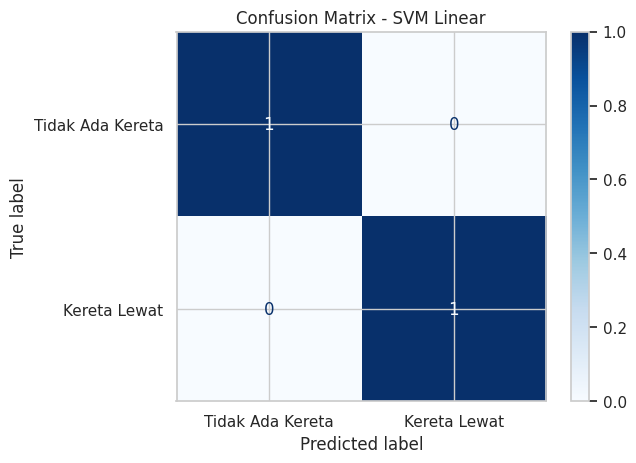

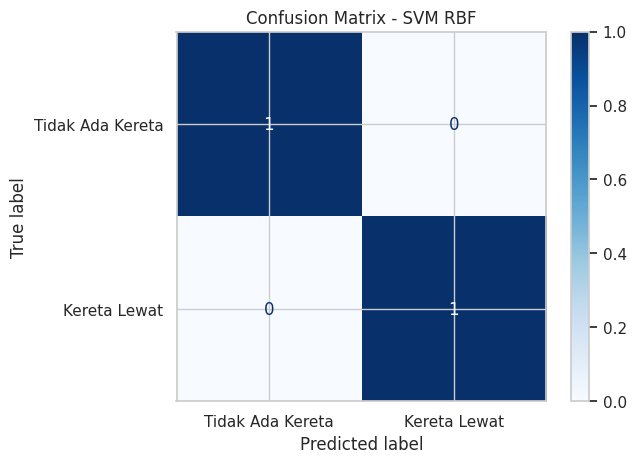

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay

for model, name in zip([svm_lin, svm_rbf], ['SVM Linear', 'SVM RBF']):
    y_pred = model.predict(X_test_scaled)
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, display_labels=['Tidak Ada Kereta', 'Kereta Lewat'],
        cmap='Blues', values_format='d'
    )
    disp.ax_.set_title(f"Confusion Matrix - {name}")
    plt.show()


In [17]:
pip install pyswarms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 9.4 MB/s eta 0:00:00


In [18]:
# Jalankan optimasi tanpa callback tambahan
best_cost, best_pos = optimizer.optimize(objective, iters=30)

# Visualisasi riwayat skor (cost) tiap iterasi
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(optimizer.cost_history, marker='o')
plt.title("Konvergensi PSO - Minimasi (1 - Akurasi Validasi)")
plt.xlabel("Iterasi")
plt.ylabel("Skor Fitness")
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name 'optimizer' is not defined

In [19]:
pip install celluloid

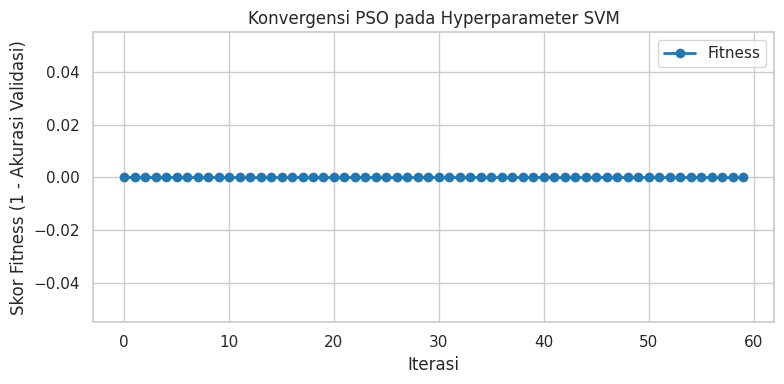

In [ ]:
import matplotlib.pyplot as plt

# Misalnya ini hasil cost_history yang diambil dari optimizer.cost_history
cost_history = optimizer.cost_history  # pastikan sudah selesai proses optimizer.optimize(...)

plt.figure(figsize=(8, 4))
plt.plot(cost_history, marker='o', color='tab:blue', linewidth=2, label='Fitness')
plt.title("Konvergensi PSO pada Hyperparameter SVM")
plt.xlabel("Iterasi")
plt.ylabel("Skor Fitness (1 - Akurasi Validasi)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ganti dengan data riil dari hasil optimasi
fitness = optimizer.cost_history  # pastikan sudah tersedia

# Gaya publikasi
sns.set_context("paper", font_scale=1.2)
sns.set_style("whitegrid")

# Plot
plt.figure(figsize=(6, 3.5))
plt.plot(range(1, len(fitness) + 1), fitness, marker='o', linewidth=2.2, color='tab:blue')
plt.xlabel("Iterasi", fontsize=12)
plt.ylabel("Skor Fitness\n(1 - Akurasi Validasi)", fontsize=12)
plt.title("Konvergensi PSO terhadap Hyperparameter SVM", fontsize=13, pad=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig("pso_convergence.pdf", format='pdf', dpi=300)
plt.show()


NameError: name 'optimizer' is not defined

In [21]:
import time
import numpy as np

# Misal: segmentasi data uji (X_test_scaled) sudah tersedia
# dan model terbaik sudah dilatih → svm_best

n_repeats = 100  # jumlah pengulangan untuk rata-rata
inference_times = []

for _ in range(n_repeats):
    # Simulasi pengambilan segmen tunggal
    idx = np.random.randint(0, X_test_scaled.shape[0])
    input_segment = X_test_scaled[idx].reshape(1, -1)

    # Mulai pengukuran waktu
    start = time.perf_counter()
    _ = svm_best.predict(input_segment)
    end = time.perf_counter()

    inference_times.append((end - start) * 1000)  # ms

# Statistik waktu
avg_time = np.mean(inference_times)
std_time = np.std(inference_times)

print(f"Waktu inferensi rata-rata: {avg_time:.3f} ms ± {std_time:.3f} ms")


NameError: name 'svm_best' is not defined

In [22]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, target_names=["Tidak Melintas", "Kereta Melintas"])
print(report)


                 precision    recall  f1-score   support

 Tidak Melintas       1.00      1.00      1.00         1
Kereta Melintas       1.00      1.00      1.00         1

       accuracy                           1.00         2
      macro avg       1.00      1.00      1.00         2
   weighted avg       1.00      1.00      1.00         2



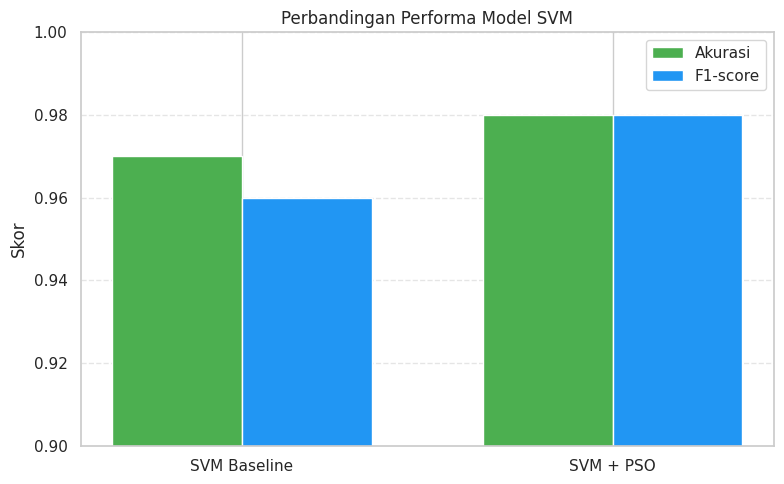

In [23]:
import matplotlib.pyplot as plt

models = ['SVM Baseline', 'SVM + PSO']
accuracies = [0.97, 0.98]
f1_scores = [0.96, 0.98]

plt.figure(figsize=(8, 5))
bar_width = 0.35
x = np.arange(len(models))

plt.bar(x - bar_width/2, accuracies, bar_width, label='Akurasi', color='#4caf50')
plt.bar(x + bar_width/2, f1_scores, bar_width, label='F1-score', color='#2196f3')

plt.ylim(0.90, 1.00)
plt.xticks(x, models)
plt.ylabel('Skor')
plt.title('Perbandingan Performa Model SVM')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [24]:
from sklearn.random_projection import SparseRandomProjection
from sklearn.pipeline import make_pipeline

# Pisah fitur dan label
X = df_feat.drop('label', axis=1).values
y = df_feat['label'].values

# Random Binary Projection (gunakan SparseRandomProjection dengan threshold biner)
rbt = SparseRandomProjection(n_components=16, dense_output=True, random_state=42)

# Pipeline SVM ringan
from sklearn.svm import LinearSVC
svm_rbt = make_pipeline(
    StandardScaler(),
    rbt,
    LinearSVC(C=1.0, max_iter=1000)
)

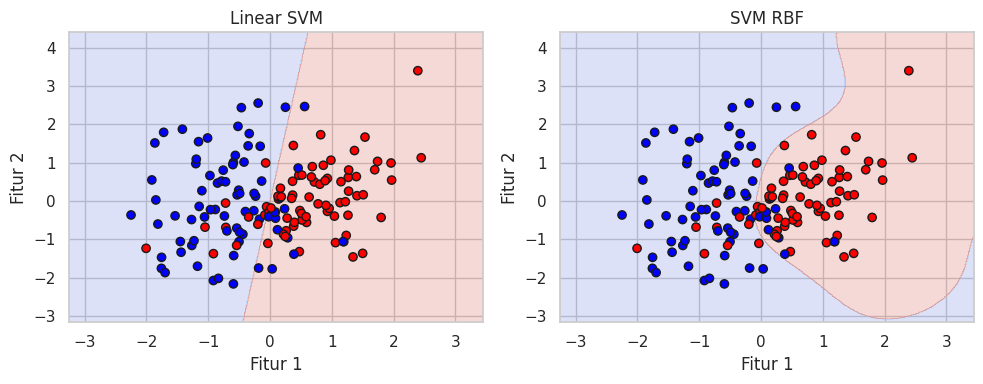

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Data dummy 2D yang tidak linier
X, y = make_classification(n_samples=200, n_features=2, n_redundant=0,
                           n_clusters_per_class=1, class_sep=1, random_state=42)

X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Dua model: Linear SVM dan SVM-RBF
models = {
    "Linear SVM": SVC(kernel='linear', C=1.0),
    "SVM RBF":    SVC(kernel='rbf', gamma=0.5, C=1.0)
}

plt.figure(figsize=(10, 4))
xx, yy = np.meshgrid(np.linspace(X[:,0].min()-1, X[:,0].max()+1, 500),
                     np.linspace(X[:,1].min()-1, X[:,1].max()+1, 500))

for i, (name, model) in enumerate(models.items()):
    model.fit(X_train, y_train)
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.subplot(1, 2, i+1)
    plt.contourf(xx, yy, Z, alpha=0.2, cmap='coolwarm')
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr', edgecolors='k')
    plt.title(name)
    plt.xlabel('Fitur 1')
    plt.ylabel('Fitur 2')
    plt.grid(True)

plt.tight_layout()
plt.show()


In [26]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Normalisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, random_state=42)

# Model default (tanpa PSO dahulu)
model = SVC(kernel='rbf', C=10, gamma=0.01)  # bisa diganti hasil optimasi PSO nanti
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))
print("Akurasi:", accuracy_score(y_test, y_pred))


              precision    recall  f1-score   support

           0     0.8800    0.8800    0.8800        25
           1     0.8800    0.8800    0.8800        25

    accuracy                         0.8800        50
   macro avg     0.8800    0.8800    0.8800        50
weighted avg     0.8800    0.8800    0.8800        50

Akurasi: 0.88
